#### 분류평가
- 정확도만으로 불균형한 레이블 데이터 세트에서 평가지표로 사용하기에는 부적합
- 정확도가 가지는 분류 평가 지표로의 한계점을 극복하기 위해 여러가지 분류 지표와 함께 적용해야 함

#### Confusion Matrix(혼동행렬, 오차행렬)
- 이진분류에서 성능 지표로 잘 활용되는 오차행렬은 학습된 분류 모델이 예측을 수행하면 얼마나 혼동될 수 있는지도 함께 보여주는 지표
- 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 보여줌

#### 평가 지표
- TP,FP,FN,TN 예측클래스와 실제 클래스의 Positive 결정 값과 Negative 결정 값의 결합에 따라 결정
- 앞문자 True/False는 예측값과 실제값이 같은가/틀린가를 의미하고 뒤 문자 N/P는 예측 결과값이 부정/긍정을 의미
- 정확도 = (TP + TN) / (TP + TN + FP + FN)
- 정밀도 = TP / (TP + FP) : P로 예측한 것중에서 실제도 P
- 재현율 = TP / (TP + FN) : 실제 P인 것중에서 예측도 P
- F1 = 2 * (정밀도 * 재현율) / (정밀도 + 재현율) : 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼때 높아짐
- 정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
- 재현율이 중요 지표인 경우 : 양성 데이터를 음성으로 잘못 판단하면 업무상 큰 영향이 발생하는 경우(암진단, 보험사기)
- 정밀도가 더 중요한 지표인 사례 : 스팸 메일 여부를 판단하는 경우로 스팸 메일이 아닌데 스팸 메일로 분류해서 업무 차질 발생.

#### 정밀도 및 재현율 활용 시 유의사항
- 정밀도와 재현율 성능 수치는 어느 한쪽만 참조하면 극단적인 수치 조작이 가능
- 정밀도 100%가 되는 방법 : 확실한 기준이 되는 경우만 P로 예측하고 나머지는 모두 N로 예측 TP/(TP+FP) = 1/(1+0) = 1
- 재현율이 100%가 되는 방법 : 실제 양성 1000명중 30명 TP/(TP + FN) = 30/(30 + 0) = 1
- 분류가 정밀도, 재현율 중 하나에 상대적인 중요도를 부여할 수 있지만 하나만 강조해서는 안됨
- 암 예측 모델에서 재현율을 높인다고 주로 양성만 판정한다면 환자의 불만과 불평이 커지게 됨

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    print(f'오차행렬: \n {confusion}')
    print(f'정확도: {round(accuracy,4)}, 정밀도: {round(precision,4)}, 재현율: {round(recall,4)}')
        

In [2]:
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler



def fillnas(df):
    def callname(x):
        m = re.compile('[A-Za-z]+[.]')
        p = re.findall(m,x)
        return p[0]
    
    df['Callname']=df.Name.apply(lambda x:callname(x))
    
    df1 = df.loc[df.Age.isnull()]
    age_nulllist = list(set(df1.Callname.values.tolist()))
    
    df2 = df.loc[df.Age.notnull()]
    pivot = pd.pivot_table(df2, index = 'Callname', values = 'Age',aggfunc = 'mean')
    
    for age in age_nulllist:
        df.loc[(df.Age.isnull())&(df.Callname == age),['Age']]=(pivot.loc[age][0])
        
    df['Embarked'].fillna(method = 'ffill',inplace=True)
    
    df3 = df.loc[df.Cabin.notnull()]

    df3['Cabins'] = df3['Cabin'].str[:1]
    df4 = df.loc[df.Cabin.isnull()]
    
    for i in range(1,4):
        df33 = df3.loc[df3.Pclass == i]
        cabin_fill_list=list(set(df33.Cabins.values.tolist()))
        df44 = df4.loc[df4.Pclass == i]
        fill_index = list(df44.index)
        for index in fill_index:
            df.loc[index,'Cabin'] = np.random.choice(cabin_fill_list)
            
    return df

# 불필요 항목 제거
def drop_feat(df):
    df.drop(['PassengerId','Name','Ticket','Callname'],axis=1,inplace = True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    scaler = MinMaxScaler()
    scaler.fit(df[['Fare']])
    fare_scaled = scaler.transform(df[['Fare']])
    df['Fare'] = fare_scaled
    
    return df

def transform_features(df):
    df = fillnas(df)
    df = drop_feat(df)
    df = format_features(df)
    return df

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

t_df = pd.read_csv('./dataset/train.csv')
y_t_df = t_df['Survived']
X_t_df = t_df.drop('Survived',axis=1)
X_t_df = transform_features(X_t_df)
X_t_df.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,0.014151,4,2
1,1,0,38.0,1,0,0.139136,2,0
2,3,0,26.0,0,0,0.015469,6,2
3,1,0,35.0,1,0,0.103644,2,2
4,3,1,35.0,0,0,0.015713,4,2


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_t_df, y_t_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차행렬: 
 [[107  11]
 [ 14  47]]
정확도: 0.8603, 정밀도: 0.8103, 재현율: 0.7705


In [5]:
# Q. 오차행렬을 보고 수작업으로 계산하여 아래를 구하세요.
TN = 109; FP=9; FN=15; TP=46;
accuracy = round((TP+TN)/(TP+TN+FP+FN),4)
precision = round((TP)/(TP+FP),4)
recall = round((TP)/(TP+FN),4)
print('accuracy :', accuracy)
print('precision :', precision)
print('recall :', recall)
print('f1 score :',round( 2*(precision*recall)/(precision+recall),4))

accuracy : 0.8659
precision : 0.8364
recall : 0.7541
f1 score : 0.7931


In [6]:
# Precision/Recall Trade-off
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)], axis=1)
pred_proba_result[:3]

array([[0.54240477, 0.45759523, 0.        ],
       [0.88197341, 0.11802659, 0.        ],
       [0.8787534 , 0.1212466 , 0.        ]])

In [7]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [8]:
custom_threshold = 0.5
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)
custom_predict
get_clf_eval(y_test,custom_predict)

오차행렬: 
 [[107  11]
 [ 14  47]]
정확도: 0.8603, 정밀도: 0.8103, 재현율: 0.7705


In [9]:
# 분류 결정 임계값을 0.5 -> 0.4
custom_threshold = 0.4

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)
custom_predict
get_clf_eval(y_test,custom_predict)

오차행렬: 
 [[98 20]
 [11 50]]
정확도: 0.8268, 정밀도: 0.7143, 재현율: 0.8197


In [10]:
# Q. 임계값을 [0.4, 0.45, 0.50, 0.55, 0.60] 으로 변경 시 각 평가지표의 변화를 출력하세요.

In [11]:
custom_threshold_list = [0.4, 0.45, 0.50, 0.55, 0.60]

for i in custom_threshold_list:
    binarizer = Binarizer(threshold=i).fit(pred_proba_1)
    custom_predict = binarizer.transform(pred_proba_1)
    print('임곗값:', i)
    
    result = get_clf_eval (y_test, custom_predict)
    print()

임곗값: 0.4
오차행렬: 
 [[98 20]
 [11 50]]
정확도: 0.8268, 정밀도: 0.7143, 재현율: 0.8197

임곗값: 0.45
오차행렬: 
 [[101  17]
 [ 13  48]]
정확도: 0.8324, 정밀도: 0.7385, 재현율: 0.7869

임곗값: 0.5
오차행렬: 
 [[107  11]
 [ 14  47]]
정확도: 0.8603, 정밀도: 0.8103, 재현율: 0.7705

임곗값: 0.55
오차행렬: 
 [[111   7]
 [ 15  46]]
정확도: 0.8771, 정밀도: 0.8679, 재현율: 0.7541

임곗값: 0.6
오차행렬: 
 [[112   6]
 [ 18  43]]
정확도: 0.8659, 정밀도: 0.8776, 재현율: 0.7049



In [12]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test,pred)
print(f'f1 score: {round(f1,4)}')

f1 score: 0.7899


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    print(f'오차행렬: \n {confusion}')
    print(f'정확도: {round(accuracy,4)}, 정밀도: {round(precision,4)}, 재현율: {round(recall,4)}, f1 score: {round(f1,4)}')

In [14]:
get_clf_eval(y_test,pred)

오차행렬: 
 [[107  11]
 [ 14  47]]
정확도: 0.8603, 정밀도: 0.8103, 재현율: 0.7705, f1 score: 0.7899


In [15]:
# [과제] 임곗값을 0 ~ 1로 변경시킬 때 precision과 recall의 변화 추세를 시각화하여 출력하세요

#### ROC Curve와 AUC
- 수신자 판단 곡선이라고 하며 ML의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표
- FPR이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선으로 FPR = 1 - TNR(특이성), TPR은 재현율(민감도)를 나타냄
- TNR = TN/(TN + FP)이며 FPR은 FP/(TN + FP)
- ROC 곡선은 FPR을 0부터 1까지 변경하면서 FPR을 구하고 이 FPR 값의 변화에 따른 TPR의 변화 값을 구함
- FPR을 0에서 1까지 변경하는 것은 P 예측값을 결정하는 기준인 분류 결정 임곗값을 변경하면 됨
- FPR을 0으로 만들려면 임곗값을 1로 지정하고 반대로 FPR을 1로 만들려면 임곗값을 0으로 지정

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba_c1)

    plt.plot(fprs, tprs, label = 'ROC')
    plt.plot([0,1],[0,1], 'k--', label='Random')

    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - Specificity)')
    plt.ylabel('TPRRecall)')
    plt.legend()
    plt.show()

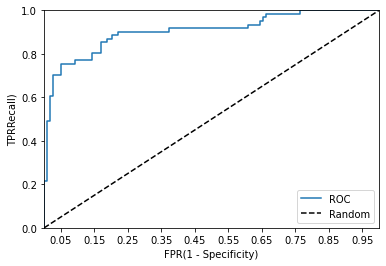

In [22]:
roc_curve_plot(y_test,pred_proba_c1)

In [18]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test,pred_proba)
round(roc_score,4)

0.9054

In [19]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    print(f'오차행렬: \n {confusion}')
    print(f'정확도: {round(accuracy,4)}, 정밀도: {round(precision,4)}, 재현율: {round(recall,4)}, \
    f1 score: {round(f1,4)}, auc: {round(roc_auc,4)}')

In [20]:
get_clf_eval(y_test,pred,pred_proba)

오차행렬: 
 [[107  11]
 [ 14  47]]
정확도: 0.8603, 정밀도: 0.8103, 재현율: 0.7705, f1 score: 0.7899, auc: 0.9054


[과제] train.csv 파일을 불러와서 분류모델링 평가를 아래와 같이 수행하세요.
- dt 모델을 적용하고 GridSearchCV를 사용, 교차검증과 성능 개선을 위한 하이퍼파라미터 튜닝
- accuracy에 추가하여 confusion matrix, accuracy, precision, recall, roc auc score 평가


[과제] diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.

- SkinThickness 와 Insulin의 0 값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가<BR>
※ 피처 정보
'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압), 'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린), 'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'


- 데이터 세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터임.
- 고립된 지역에서 인디언 고유의 혈통이 지속돼 왔지만 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생


In [23]:
diabetes_data = pd.read_csv('./dataset/diabetes.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


[도전과제] 

 아래는 백화점 고객의 1년 간 구매 데이터이다.
 
(가) 제공 데이터 목록  
① y_train.csv : 고객의 성별 데이터 (학습용), CSV 형식의 파일  
② X_train.csv, X_test.csv : 고객의 상품구매 속성 (학습용 및 평가용), CSV 형식의 파일  
(나) 데이터 형식 및 내용  
① y_train.csv (3,500명 데이터)  
② X_train.csv (3,500명 데이터), X_test.csv (2,482명 데이터)  

고객 3,500명에 대한 학습용 데이터(y_train.csv, X_train.csv)를 이용하여 성별예측 모형을 만든 
후, 이를 평가용 데이터(X_test.csv)에 적용하여 얻은 2,482명 고객의 성별 예측값(남자일 확률)을 
다음과 같은 형식의 CSV 파일로 생성하시오.(제출한 모델의 성능은 ROC-AUC 평가지표에 따라 
채점)  

<제출형식>
 custid,gender  
 3500,0.267  
 3501,0.578  
 3502,0.885  
 ․ ․ ․ 
 
 <유의사항>  
성능이 우수한 예측모형을 구축하기 위해서는 적절한 데이터 전처리, Feature Engineering, 분류 
알고리즘 사용, 초매개변수 최적화, 모형 앙상블 등이 수반되어야 한다